<div align="center"> <h1> 
Bamboost<br/>
🐼🐼🐼🐼
</h1> </div>

Bamboost is a Python library built for datamanagement using the HDF5 file format.
bamboost stands for a lightweight shelf which will boost your efficiency and which
will totally break if you load it heavily. Just kidding, bamboo can fully carry pandas. 

### Installation
Requirements for the library: `h5py`, `mpi4py`, `numpy`, `pandas`

In addition, for the model in this tutorial: `scipy` 


> Clone the repo ([link](https://gitlab.ethz.ch/compmechmat/research/libs/dbmanager)):
> ```
> git clone git@gitlab.ethz.ch:compmechmat/research/libs/dbmanager.git 
> ```
 
> Install the package using pip:
> ```
> pip install -e .
> ```

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from bamboost import Manager

from lattice_model import LatticeModel  # this is the small model we will use for fun

### Mockup problem

To try out _bamboost_ we will look at a discrete RVE made up of trusses. The specimen is a unit square $x\in[0,1]$ and $y\in[0,1]$.
- `N` controls the amount of nodes
- `E` is the young's modulus which we will keep constant and equal to $1$ for brevity
- `randomness` is a parameter we use to randomly move the points away from their position in a regular grid. The larger it is, the further the points are moved from the initial position.

We will fix the bottom of the sample and move the top horizontally.
The system is solved using the direct stiffness method under the small strain assumption.
However, the sample can be "loaded" incrementally to imititate geometrical nonlinearities.
I have no clue whether the model is justified, but this tutorial is about using bamboost to store and retrieve data, so it doesn't matter at all :)

We will record the 
- the **nodal displacements**
- the **nodal forces** 
- the total **reaction force** at the bottom edge

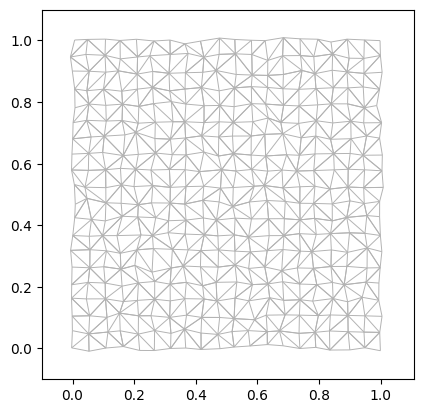

In [23]:
# You can try the effect of N and randomness here
E = 1
N = 20
randomness = .1
step = .1

model = (
    LatticeModel(E)
    .create_structure(N)
    .add_randomness(randomness)
    .move_top(step)
)

model.plot()

Let's compute the response of 20 steps where in each step we move the top edge by 0.1...

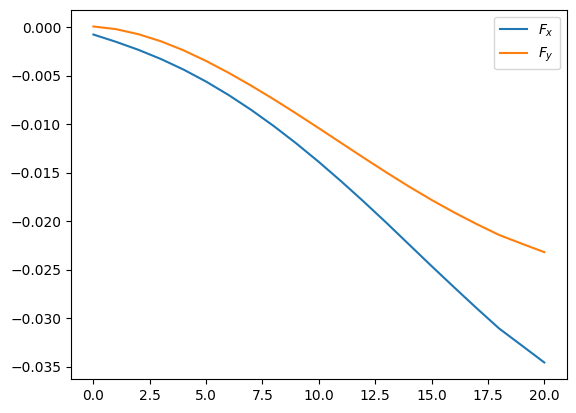

In [31]:
E = 1
N = 10
randomness = 0.3
step = .1

model = (
    LatticeModel(E)
    .create_structure(N)
    .add_randomness(randomness)
    .move_top(step)
)

timesteps = np.linspace(0, .2, 21)  # pseudo timesteps, in each step we move the top edge by the same amount
bottom_forces = list()

for t in timesteps:
    model.solve()
    bottom_forces.append(model.get_force_bottom())
    
plt.plot(bottom_forces, label=('$F_x$', '$F_y$'))
plt.legend()

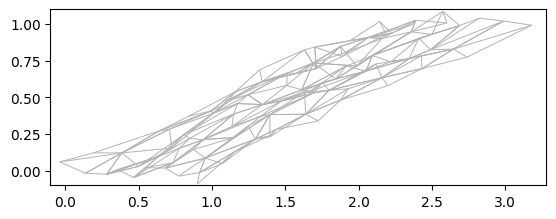

In [11]:
model.plot()

## Save the data

In [5]:
# create the database
from bamboost import Manager
db = Manager('out')
db.df

,id,notes,status,E,N,processors,randomness,time_stamp
0,test_sim,,Initiated,1,20,1,0.2,2023-09-02 11:46:33


In [119]:
parameters = {
    'E': 1,
    'N': 10,
    'randomness': 1e-2,
}

writer = db.create_simulation(parameters=parameters)

model = (
    LatticeModel(parameters['E'])
    .create_structure(parameters['N'])
    .add_randomness(parameters['randomness'])
)
u_top = 0.1
model.move_top(u_top)

writer.add_mesh(model.coordinates, model.connectivity)
writer.add_metadata()
writer.change_note('This is the initial test...')

timesteps = np.linspace(0, 1, 40)

for t in timesteps:
    model.solve()
    model.end_step()
    sum_of_force_on_bottom = model.forces[model.bottom_indices].sum(axis=0)
    
    writer.add_field('nodal_displacements', model.displacements, time=t)
    writer.add_field('nodal_forces', model.forces, time=t)
    writer.add_global_field('top_force_x', sum_of_force_on_bottom[0])
    writer.add_global_field('top_force_y', sum_of_force_on_bottom[1])
    
    writer.finish_step()


The parameter space may already exist. Here are the duplicates:
         id                        notes  ... randomness           time_stamp
0  3ab909b4  This is the initial test...  ...       0.01  2023-09-01 21:15:49

[1 rows x 8 columns]


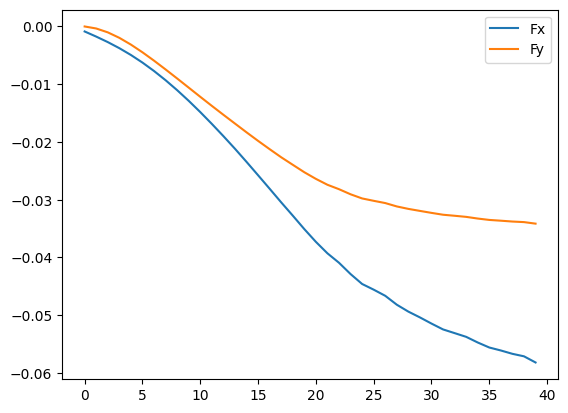

In [121]:
db = Manager('out')
sim = db[0]
plt.plot(sim.globals['top_force_x'], label='Fx')
plt.plot(sim.globals['top_force_y'], label='Fy')
plt.legend()

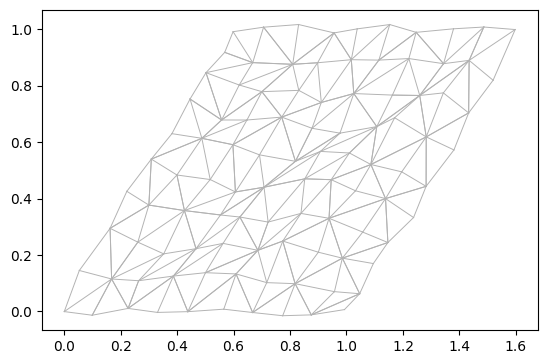

In [132]:
# plot the displacement at step 10
def plot(ax, coords, connectivity, displacement):
    for el in connectivity:
        ax.plot(coords[el, 0]+displacement[el, 0], coords[el, 1]+displacement[el, 1], c='.7', lw=.7)
    ax.set_aspect('equal')

displacements = sim.data['nodal_displacements']
plot(plt.gca(), displacements.coordinates, displacements.connectivity, displacements[5])